### Task 1 


In [1]:
import numpy as np
from math import pi

from qiskit import QuantumCircuit, Aer, execute, QuantumRegister 
from qiskit.circuit import ParameterVector
from qiskit.compiler import transpile
from qiskit_textbook.tools import array_to_latex

from qiskit.visualization import plot_bloch_multivector, plot_histogram, plot_state_qsphere, plot_bloch_vector

In [2]:
num_qubits = 4
L = 2 # number of layers
theta = ParameterVector('theta', length=num_qubits)

In [3]:
phi_state = np.exp(1j*np.random.rand(num_qubits**2))
array_to_latex(phi_state, pretext="\\text{Random State} = ")

<IPython.core.display.Math object>

### Unitary Gates Circuit

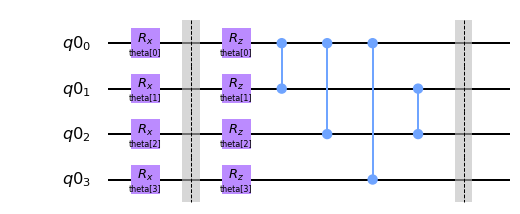

In [4]:
U_reg = QuantumRegister(num_qubits)
U_gateset = QuantumCircuit(U_reg, name='U_gateset')

for i in range(num_qubits):
    U_gateset.rx(theta[i], i)
U_gateset.barrier()

for i in range(num_qubits):
    U_gateset.rz(theta[i], i)
U_gateset.cz(0, 1)
U_gateset.cz(0, 2)
U_gateset.cz(0, 3)
U_gateset.cz(1, 2)
U_gateset.barrier()

U_gateset.draw('mpl')

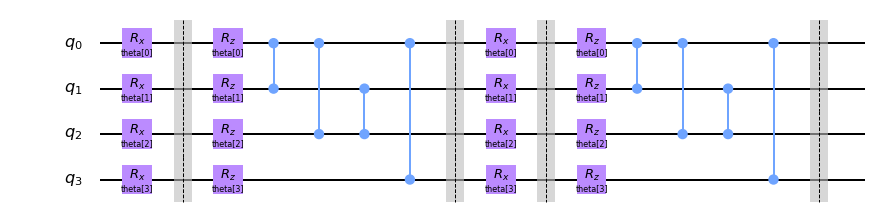

In [5]:
# Convert to a gate and stick it into an arbitrary place in the bigger circuit

U_inst = U_gateset.to_instruction()

qr = QuantumRegister(4, 'q')
qc = QuantumCircuit(qr)

for _ in range(L):
    qc.append(U_inst, [qr[0], qr[1], qr[2], qr[3]])
 
qc.decompose().draw('mpl')

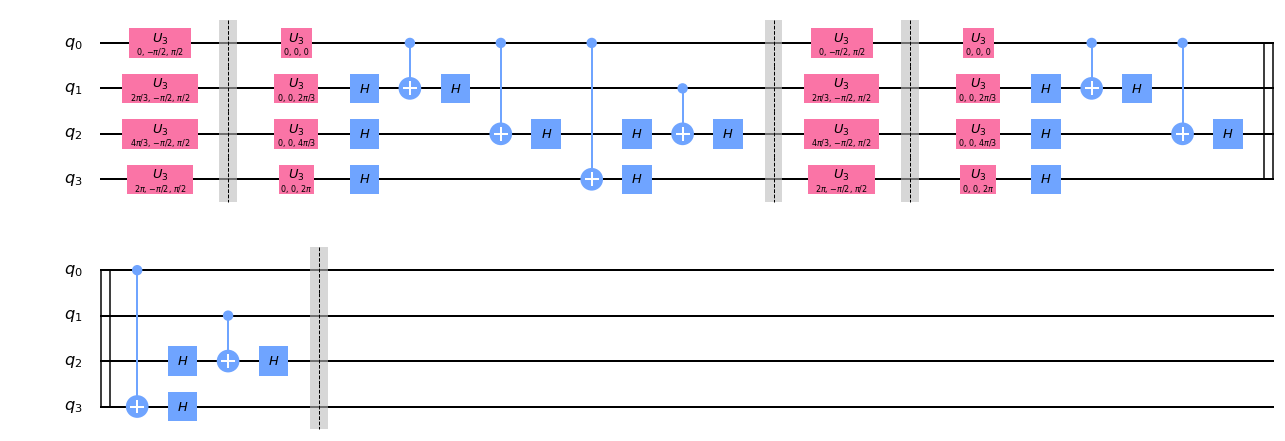

In [6]:
p = np.linspace(0, 2 * np.pi, 4)

statevector_backend = Aer.get_backend('statevector_simulator')
transpiled_qc = transpile(qc, backend=statevector_backend)
big_qc = transpiled_qc.bind_parameters({theta:p})
big_qc.decompose().draw('mpl')

In [10]:
final_state = execute(big_qc, 
                      statevector_backend).result().get_statevector()

array_to_latex(final_state, pretext="\\text{Final State} = ")

<IPython.core.display.Math object>

In [11]:
epsi = np.sum(np.abs(final_state-phi_state)**2)
epsi

16.358583378871224

## Genetic Algorithm

In [12]:
sol_per_pop = 16

In [13]:
pool = 2*np.pi*np.random.rand(4)
pool

array([0.29179893, 3.50604788, 0.75765847, 5.40383525])

In [14]:
def init_pop(sol_per_pop):
  population = []
  for i in range(sol_per_pop):
    sol = 2*np.pi*np.random.rand(4)
    population.append(sol)
  return population

pop0 = init_pop(sol_per_pop)
pop0

[array([5.06137125, 3.8655297 , 4.83489938, 2.74485337]),
 array([2.72587716, 5.69383446, 5.47697618, 2.77773736]),
 array([1.68462725, 5.73593931, 3.68229849, 3.73499187]),
 array([2.10641948, 5.75434873, 0.77475117, 2.63283547]),
 array([3.75117049, 5.83679106, 1.57932263, 3.38942371]),
 array([1.47940716, 3.70961469, 3.99088371, 4.09268884]),
 array([3.80168241, 6.01909393, 2.22083467, 3.98118487]),
 array([2.90373927, 3.08561856, 0.07983285, 4.85945857]),
 array([2.83607097, 2.66222629, 4.07725694, 2.15151765]),
 array([5.77397171, 4.67109263, 0.26086233, 0.28758294]),
 array([2.40842702, 2.00820377, 5.54174577, 4.69196182]),
 array([4.15943883, 1.05099487, 3.68200598, 5.47978211]),
 array([2.8889943 , 2.69229738, 3.96610085, 5.65940186]),
 array([4.80381326, 0.85631044, 4.95945484, 0.81229702]),
 array([5.69100873, 0.80284588, 4.84959208, 4.70492185]),
 array([0.19813754, 5.58233612, 5.75735931, 3.6887068 ])]

In [16]:
def cal_fitness(population, transpiled_qc):
  fitness = []

  for sol in population:
      big_qc = transpiled_qc.bind_parameters({theta:sol})
      final_state = execute(big_qc, statevector_backend).result().get_statevector()
      fit = np.sum(np.abs(final_state-phi_state)**2)
      fitness.append(-fit)      
  return fitness

fit0 = cal_fitness(pop0, transpiled_qc)
fit0

[-14.48458926532829,
 -16.71539093491349,
 -14.273768549945778,
 -15.528058631942432,
 -18.223598505147226,
 -17.481431441400492,
 -16.635923054925094,
 -18.092121357703817,
 -19.100531304401997,
 -15.869568695368635,
 -14.873583515635413,
 -16.686281878735247,
 -17.681693515210206,
 -16.089356315884622,
 -16.11621954532294,
 -14.41546635090905]

In [17]:
def select_mating_pool(population, fitness, num_parents):
    # Selecting the best individuals in the current generation as parents for producing the offspring of the next generation.
    parents = []
    for parent_num in range(num_parents):
        max_fitness_idx = fitness.index(max(fitness))
        parents.append(population[max_fitness_idx])
        fitness[max_fitness_idx] = -999
    return parents

mpool = select_mating_pool(pop0, fit0, sol_per_pop//2)
mpool

[array([1.68462725, 5.73593931, 3.68229849, 3.73499187]),
 array([0.19813754, 5.58233612, 5.75735931, 3.6887068 ]),
 array([5.06137125, 3.8655297 , 4.83489938, 2.74485337]),
 array([2.40842702, 2.00820377, 5.54174577, 4.69196182]),
 array([2.10641948, 5.75434873, 0.77475117, 2.63283547]),
 array([5.77397171, 4.67109263, 0.26086233, 0.28758294]),
 array([4.80381326, 0.85631044, 4.95945484, 0.81229702]),
 array([5.69100873, 0.80284588, 4.84959208, 4.70492185])]

In [18]:
def crossover(parents, offspring_size):
    offsprings = []
    # The point at which crossover takes place between two parents. Usually it is at the center.
    crossover_point = num_qubits//2

    for i in range(sol_per_pop//2):
        # Index of the first parent to mate.
        parent1_idx = i%len(parents)
        # Index of the second parent to mate.
        parent2_idx = (i+1)%len(parents)
        offspring = np.concatenate((parents[parent1_idx][:crossover_point],parents[parent2_idx][crossover_point:]), axis=0)
        offsprings.append(offspring)

    return offsprings

ofc = crossover(mpool, 2)
ofc

[array([1.68462725, 5.73593931, 5.75735931, 3.6887068 ]),
 array([0.19813754, 5.58233612, 4.83489938, 2.74485337]),
 array([5.06137125, 3.8655297 , 5.54174577, 4.69196182]),
 array([2.40842702, 2.00820377, 0.77475117, 2.63283547]),
 array([2.10641948, 5.75434873, 0.26086233, 0.28758294]),
 array([5.77397171, 4.67109263, 4.95945484, 0.81229702]),
 array([4.80381326, 0.85631044, 4.84959208, 4.70492185]),
 array([5.69100873, 0.80284588, 3.68229849, 3.73499187])]

In [19]:
def mutation(offspring_crossover):
    # Mutation changes a single gene in each offspring randomly.
    for idx in range(len(offspring_crossover)):
        # The random value to be added to the gene.
        random_idx = np.random.randint(num_qubits)
        random_value =  2*np.pi*np.random.rand(1)
        offspring_crossover[idx][random_idx] = random_value
    return offspring_crossover

ofm = mutation(ofc)
ofm

[array([1.68462725, 5.73593931, 5.75735931, 3.98774353]),
 array([0.19813754, 0.25497748, 4.83489938, 2.74485337]),
 array([4.59007912, 3.8655297 , 5.54174577, 4.69196182]),
 array([2.40842702, 2.00820377, 0.45552311, 2.63283547]),
 array([2.10641948, 4.32891488, 0.26086233, 0.28758294]),
 array([5.77397171, 4.67109263, 1.47946618, 0.81229702]),
 array([4.80381326, 3.51884547, 4.84959208, 4.70492185]),
 array([5.69100873, 0.80284588, 3.68229849, 0.84210155])]

In [20]:
sol_per_pop = 20
num_generations = 400

def genetic_algorithm(sol_per_pop, num_generations, transpiled_qc):
    fitness_g = []
    new_population = init_pop(sol_per_pop)
    num_parents_mating = sol_per_pop // 2

    best_fitness = -99

    for generation in range(num_generations):
    
    # Measuring the fitness of each chromosome in the population.
        fitness = cal_fitness(new_population, transpiled_qc)

    # Selecting the best parents in the population for mating.
        parents = select_mating_pool(new_population, fitness, num_parents_mating)

    # Generating next generation using crossover.
        offspring_crossover = crossover(parents, offspring_size=sol_per_pop-len(parents))

    # Adding some variations to the offsrping using mutation.
        offspring_mutation = mutation(offspring_crossover)

    # Creating the new population based on the parents and offspring.
        new_population = parents + offspring_mutation

        fit_gen = np.max(fitness)
        fitness_g.append(fit_gen)

    # Getting the best solution 
        if fit_gen > best_fitness:
            best_fitness = fit_gen
            best_fitness_idx = np.where(fitness == fit_gen)[0][0]
            best_sol = new_population[best_fitness_idx]   

    return best_fitness, best_sol, fitness_g

best_fitness, best_sol, fitness_g = genetic_algorithm(sol_per_pop, num_generations, transpiled_qc)

In [21]:
print('Fitness :', best_fitness)
print('Parameters :', best_sol)

Fitness : -12.22668881639831
Parameters : [5.99560926 5.68374161 5.59241236 5.37270629]


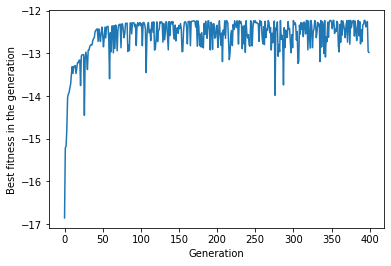

In [22]:
import matplotlib.pyplot as plt
plt.xlabel("Generation")
plt.ylabel("Best fitness in the generation")
#plt.hlines(score_threshold, 0, N, linestyles='dashed', colors='r')
plt.plot(fitness_g)

In [23]:
%%time
L = 10
y = []
for l in range(1,L):
    qr = QuantumRegister(4, 'q')
    qc = QuantumCircuit(qr)

    for _ in range(l):
        qc.append(U_inst, [qr[0], qr[1], qr[2], qr[3]])
    
    transpiled_qc = transpile(qc, backend=statevector_backend)

    best_fitness, best_sol, fitness_g = genetic_algorithm(20, 400, transpiled_qc)
    y.append(best_fitness)    

CPU times: user 1h 24min 52s, sys: 48.6 s, total: 1h 25min 41s
Wall time: 33min 13s


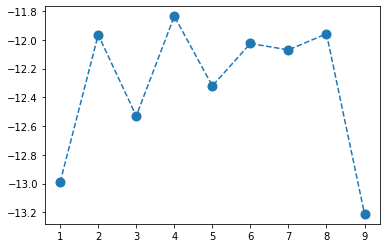

In [24]:
plt.plot(list(range(1,L)), y, linestyle='dashed', marker='o', markersize=9) 